In [2]:
using DrWatson
@quickactivate :SwARExperiments

┌ Info: Precompiling SwARExperiments [370ede80-34d9-4915-b06a-c76e3bd073fe]
└ @ Base loading.jl:1317


In [3]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Plots
using Random
using Parameters
using LinearAlgebra
import ProgressMeter

In [4]:
using Plots
pgfplotsx()
push!(PGFPlotsX.CUSTOM_PREAMBLE, raw"\usepgfplotslibrary{fillbetween}");

In [5]:
function ar_ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ar_ssm (generic function with 1 method)

In [6]:
using WAV
signal, fs = WAV.wavread("../data/btb.wav")
# signal = signal[1:2:end]

([-0.0019226660969878231; -0.005615405743583483; … ; -0.0067445905941953795; -0.0025940733054597613], 8000.0f0, 0x0010, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x01, 0x00, 0x40, 0x1f, 0x00, 0x00, 0x80, 0x3e, 0x00, 0x00, 0x02, 0x00, 0x10, 0x00]), WAVChunk(:LIST, UInt8[0x49, 0x4e, 0x46, 0x4f, 0x49, 0x4e, 0x41, 0x4d, 0x08, 0x00  …  0x73, 0x70, 0x65, 0x63, 0x74, 0x6f, 0x72, 0x4a, 0x00, 0x00]), WAVChunk(Symbol("id3 "), UInt8[0x49, 0x44, 0x33, 0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x26  …  0x49, 0x6e, 0x73, 0x70, 0x65, 0x63, 0x74, 0x6f, 0x72, 0x4a])])

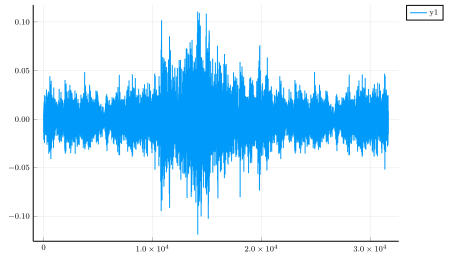

In [26]:
plot(signal)

In [8]:
inputs_bar, outputs_bar = ar_ssm(signal[1:20000], 2)
inputs_train, outputs_train = ar_ssm(signal[20000:40000], 2)

([[-0.0033875545518356883, -0.0022583697012237922], [-0.007232886745811335, -0.0033875545518356883], [-0.007904293954283274, -0.007232886745811335], [-0.003784295175023652, -0.007904293954283274], [0.004547257911923582, -0.003784295175023652], [0.008575701162755212, 0.004547257911923582], [0.015015106662190619, 0.008575701162755212], [0.02011169774468215, 0.015015106662190619], [0.023651844843897825, 0.02011169774468215], [0.025849177526169623, 0.023651844843897825]  …  [0.0228278450880459, 0.020264290292062136], [0.027314065981017488, 0.0228278450880459], [0.014435254982146673, 0.027314065981017488], [0.008636738181707206, 0.014435254982146673], [-0.002075258644367809, 0.008636738181707206], [-0.021912289803765986, -0.002075258644367809], [-0.006134220404675436, -0.021912289803765986], [-0.008423108615375225, -0.006134220404675436], [-0.011261329996642965, -0.008423108615375225], [-0.005127109591967528, -0.011261329996642965]], [-0.007232886745811335, -0.007904293954283274, -0.0037842

In [7]:
using AIDA

In [17]:
γ_bar, θ_bar, fe_bar = ar_inference(inputs_bar, outputs_bar, 2, 20)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


(Marginal(GammaShapeRate{Float64}(a=9999.000100000001, b=1.2013570169009355)), Marginal(MvNormalWeightedMeanPrecision(
xi: [18789.772256514207, 14919.095559967109]
Λ: [21007.228437531943 18789.742225448972; 18789.742225448972 21006.920591981387]
)
), [-48053.64638696441, -61859.34099950116, -61860.941720625706, -61860.941720669114, -61860.94172066968, -61860.94172066933, -61860.94172066955, -61860.94172066933, -61860.94172066949, -61860.94172066933, -61860.94172066949, -61860.94172066933, -61860.94172066949, -61860.94172066933, -61860.94172066949, -61860.94172066933, -61860.94172066949, -61860.94172066933, -61860.94172066949, -61860.94172066933])

In [18]:
γ_train, θ_train, fe_train = ar_inference(inputs_train, outputs_train, 2, 20)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


(Marginal(GammaShapeRate{Float64}(a=9999.500100000001, b=1.8101285456631173)), Marginal(MvNormalWeightedMeanPrecision(
xi: [58963.65554966758, 50910.930215281645]
Λ: [64180.865852455885 58963.161031602474; 58963.161031602474 64180.74881126579]
)
), [-34595.54266415445, -57757.59977586761, -57764.43422568755, -57764.434226107114, -57764.43422610476, -57764.434226107725, -57764.43422610793, -57764.4342261079, -57764.43422610784, -57764.43422610784, -57764.43422610784, -57764.43422610784, -57764.43422610784, -57764.43422610784, -57764.43422610784, -57764.43422610784, -57764.43422610784, -57764.43422610784, -57764.43422610784, -57764.43422610784])

In [32]:
# priors for train and bar sounds were extracted by means of bayesian AR
# see https://github.com/biaslab/AIDA/blob/master/src/environment/ar.jl
coefs_set = [mean(θ_bar), mean(θ_train)]
prec_set  = [mean(γ_bar), mean(γ_train)]
l_slice   = 15000
n_buckets = div(length(signal), l_slice)
n_states  = 2

2

## Switching AR

In [33]:
priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A = generate_priors(coefs_set, prec_set)

(GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=6.927379287079424e10, b=8.323087940830268e6), GammaShapeRate{Float64}(a=3.0516712323232964e10, b=5.524193364033609e6)], GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], MvNormalMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNormalMeanPrecision(
μ: [1.2963022142609468, -0.4492847417092366]
Λ: [10000.0 0.0; 0.0 10000.0]
)
, MvNormalMeanPrecision(
μ: [1.2177989080828675, -0.3255546763338871]
Λ: [10000.0 0.0; 0.0 10000.0]
)
], [(2, [1.0 0.0; 0.0 1.0]), (2, [1.0 0.0; 0.0 1.0])], [0.5, 0.5], [1.0 1.0; 1.0 1.0])

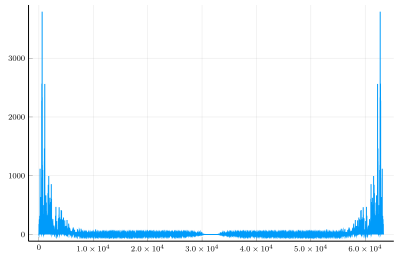

In [34]:
using FFTW
plot(abs.(fft(signal)).^2, label=false)

In [35]:

parameters = SwARParameters(n_states, priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A)

SwARParameters(2, GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=6.927379287079424e10, b=8.323087940830268e6), GammaShapeRate{Float64}(a=3.0516712323232964e10, b=5.524193364033609e6)], GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], MvNormalMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNormalMeanPrecision(
μ: [1.2963022142609468, -0.4492847417092366]
Λ: [10000.0 0.0; 0.0 10000.0]
)
, MvNormalMeanPrecision(
μ: [1.2177989080828675, -0.3255546763338871]
Λ: [10000.0 0.0; 0.0 10000.0]
)
], [(2, [1.0 0.0; 0.0 1.0]), (2, [1.0 0.0; 0.0 1.0])], [0.5, 0.5], [1.0 1.0; 1.0 1.0])

In [36]:
inputs, outputs = ar_ssm(signal, 2)
result = InferenceResults(inference_swar(inputs, outputs, n_buckets, 20, parameters)...);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


In [37]:
mean(result.mA[end])

2×2 Matrix{Float64}:
 0.408425  0.567024
 0.591575  0.432976

In [38]:
mean.(result.mθs[end])

4-element Vector{Vector{Float64}}:
 [1.2570661302499426, -0.41811831314678466]
 [1.3267159789388203, -0.425765405604873]
 [0.9984317454081847, -0.14410035913187733]
 [1.2968137319351036, -0.4607308018237293]

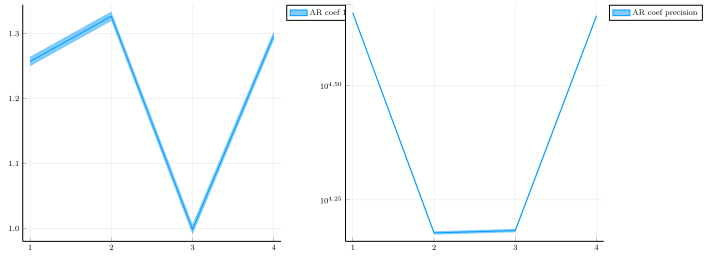

In [39]:
mθs = result.mθs
mγs = result.mγs

dimension(n) = (x) -> map(i -> i[n], x)
index = 1
p1 = plot(mean.(mθs[end]) |> dimension(index), ribbon = sqrt.(var.(mθs[end]) |> dimension(index)), label="AR coef $(index)")
# plot!([coefs_set[state][index] for state in real_states], label="generated coefs")
p2 = plot(mean.(mγs[end]), ribbon = std.(mγs[end]), yscale = :log10, label="AR coef $(precision)")
# plot!([prec_set[state] for state in real_states], label="generated coefs")

plot(p1, p2, size = (900, 400))

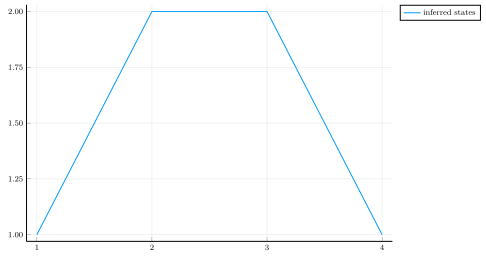

In [40]:
mzs = result.mzs
plot(mean.(mzs[end][1:end]), label="inferred states")


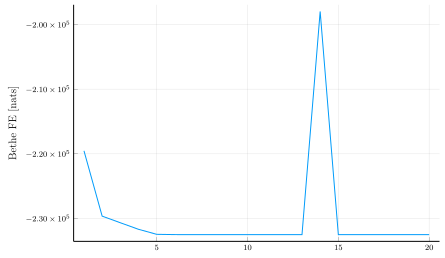

In [41]:
mfe = result.mfe
plot(mfe[1:end], label=:none, ylabel="Bethe FE [nats]")

In [ ]:
xs = collect(1:n_states)
ys = collect(1:n_states)
p1 = heatmap(xs, ys, mean(mA[end]), aspect_ratio = 1,color=:grays)
p2 = heatmap(xs, ys, gen_A, aspect_ratio = 1, color=:grays)
plot(p1, p2)

In [439]:
collect(1:n_states)

3-element Vector{Int64}:
 1
 2
 3

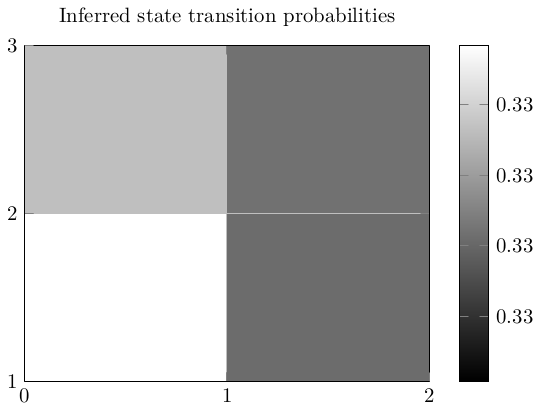

In [466]:
axis1 = @pgf Axis(
    {
        xtick=collect(0:n_states),
        ytick=collect(0:n_states),
        title="Inferred state transition probabilities",
        legend_pos = "north east",
        legend_cell_align="{left}",
        grid = "major",
        view = (0, 90),
        colorbar,
        "colormap/blackwhite",
        colorbar_style={"xticklabel pos=upper"}
    },
    Plot3(
        {
            surf,
            shader = "flat corner",
        },
        Coordinates(collect(1:3), collect(1:3), mean(mA[end]))),
    )